# Fine-Tune a Generative AI Model for Dialogue Summarization

In this notebook, you will fine-tune an existing LLM from Hugging Face for enhanced dialogue summarization. You will use the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model, which provides a high quality instruction tuned model and can summarize text out of the box. To improve the inferences, you will explore a full fine-tuning approach and evaluate the results with ROUGE metrics. Then you will perform Parameter Efficient Fine-Tuning (PEFT), evaluate the resulting model and see that the benefits of PEFT outweigh the slightly-lower performance metrics.

# Table of Contents

- [ 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM](#1)
  - [ 1.1 - Set up Kernel and Required Dependencies](#1.1)
  - [ 1.2 - Load Dataset and LLM](#1.2)
  - [ 1.3 - Test the Model with Zero Shot Inferencing](#1.3)
- [ 2 - Perform Full Fine-Tuning](#2)
  - [ 2.1 - Preprocess the Dialog-Summary Dataset](#2.1)
  - [ 2.2 - Fine-Tune the Model with the Preprocessed Dataset](#2.2)
  - [ 2.3 - Evaluate the Model Qualitatively (Human Evaluation)](#2.3)
  - [ 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)](#2.4)
- [ 3 - Perform Parameter Efficient Fine-Tuning (PEFT)](#3)
  - [ 3.1 - Setup the PEFT/LoRA model for Fine-Tuning](#3.1)
  - [ 3.2 - Train PEFT Adapter](#3.2)
  - [ 3.3 - Evaluate the Model Qualitatively (Human Evaluation)](#3.3)
  - [ 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)](#3.4)

<a name='1'></a>
## 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM

<a name='1.1'></a>
### 1.1 - Set up Kernel and Required Dependencies

Now install the required packages for the LLM and datasets.



In [2]:
%pip install -U datasets==2.17.0

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    evaluate \
    transformers==4.27.2 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.0 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 10.5 MB/s eta 

Import the necessary components. Some of them are new for this week, they will be discussed later in the notebook. 

In [4]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

2024-05-07 08:30:01.778118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 08:30:02.145756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='1.2'></a>
### 1.2 - Load Dataset and LLM

You are going to continue experimenting with the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics. 

In [5]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

Load the pre-trained [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Notice that you will be using the [small version](https://huggingface.co/google/flan-t5-base) of FLAN-T5. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.

In [122]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

It is possible to pull out the number of model parameters and find out how many of them are trainable. The following function can be used to do that, at this stage, you do not need to go into details of it. 

In [71]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


<a name='1.3'></a>
### 1.3 - Test the Model with Zero Shot Inferencing

Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [72]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)

print(f'INPUT PROMPT:\n{prompt}')

print(dash_line)

print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

print(dash_line)

print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

<a name='2'></a>
## 2 - Perform Full Fine-Tuning

<a name='2.1'></a>
### 2.1 - Preprocess the Dialog-Summary Dataset

## NOTE:
You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary: 
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [73]:
def tokenize_function(example):

    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '

    prompt = [start_prompt + dialogue + end_prompt for diaglogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, max_length =512, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, max_length=512, return_tensors="pt").input_ids

    return example
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

To save some time in the lab, you will subsample the dataset:

In [74]:
tokenized_dataset = tokenized_datasets.filter(lambda example, index:index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Check the shapes of all three parts of the dataset:

In [75]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (12460, 2)
Validation: (500, 2)
Test: (1500, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1500
    })
})


The output dataset is ready for fine-tuning.

<a name='2.2'></a>
### 2.2 - Fine-Tune the Model with the Preprocessed Dataset

Now utilize the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [76]:
tokenized_datasets['train']

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 12460
})

In [85]:
output_dir = f'./model_train-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

Start training process...



In [95]:
# train and save model to correspionding directory

In [88]:
test_model_path = './test_model'
trainer.train()
trainer.model.save_pretrained(test_model_path)
tokenizer.save_pretrained(test_model_path)

Step,Training Loss
1,45.250000


('./test_model/tokenizer_config.json',
 './test_model/special_tokens_map.json',
 './test_model/tokenizer.json')

# IMPORTANT NOTE:
IN CASE OF CUDA OUT OF MEMORY, WE WILL ABLE TO DOWNLOAD FLANT T5 MODEL FULLY FINE TUNED ON DIALOGUE SUMMARY DATASET

Training a fully fine-tuned version of the model would take a few hours on a GPU. To save time, download a checkpoint of the fully fine-tuned model to use in the rest of this notebook. This fully fine-tuned model will also be referred to as the **instruct model** in this lab.

The size of the downloaded instruct model is approximately 1GB.

In [ ]:
# HERE YOU NEED TO LOAD FULLY TRAINED MODEL 

In [92]:
pretrained_model_path = '/tf/tensorflow-tutorials/test_model/'
model_pretrained_custom_instruct = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model_path, torch_dtype = torch.bfloat16)

<a name='2.3'></a>
### 2.3 - Evaluate the Model Qualitatively (Human Evaluation)

As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [94]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = model_pretrained_custom_instruct.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
#print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1#: I'm thinking of upgrading my computer.


<a name='2.4'></a>
### 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)

The [ROUGE metric](https://en.wikipedia.org/wiki/ROUGE_(metric)) helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [102]:
rouge = evaluate.load('rouge')

In [ ]:
Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [99]:
dialogues = dataset['test'][:10]['dialogue']
human_baselines_summaries = dataset['test'][:10]['summary']

original_model_results = []
instruct_tuned_model_results = []

for _,dialogue in enumerate(dialogues):
    prompt = f"""

    Summarize the following conversation
    
    {dialogue}
    
    Summary: 
    """
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    
    # base model generation and decode
    original_model_outputs = original_model.generate(input_ids = input_ids, generation_config = GenerationConfig(
                                                                                                max_new_tokens=200))
    
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_results.append(original_model_text_output)
    
    # instructor finetuned model generation and decode
    instructor_fined_model_outputs = original_model.generate(input_ids = input_ids, generation_config = GenerationConfig(
                                                                                                max_new_tokens=200))
    instructor_fined_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    
    instruct_tuned_model_results.append(original_model_text_output)
    

zipped_summary = list(zip(human_baselines_summaries, original_model_results,instruct_tuned_model_results))

results_data_instruct = pd.DataFrame(
                    zipped_summary, 
                    columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries']

)

In [100]:
results_data_instruct.to_csv('FullFineTuned.csv', index=False)

Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

# calculate ROUGE Metrices between 2 model

In [105]:
original_base_model_results =  rouge.compute(
        predictions = original_model_results,
        references = human_baselines_summaries[0:len(original_model_results)],
        #use_aggregator (boolean): If True, returns aggregates. Defaults to True.
        use_aggregator=True,
        #If True, uses Porter stemmer to strip word suffixes. Defaults to False
        use_stemmer=True,
)

instruct_finetuned_model_results = rouge.compute(
        predictions = instruct_tuned_model_results,
        references =  human_baselines_summaries[0:len(instruct_tuned_model_results)],
      #use_aggregator (boolean): If True, returns aggregates. Defaults to True.
        use_aggregator = True,
     #If True, uses Porter stemmer to strip word suffixes. Defaults to False
        use_stemmer = True,

)

print('==================Original Model==============')
print(original_base_model_results)

print('-----------------------------------------------')

print('==================Instruct Finetuned Model results==============')
print(instruct_finetuned_model_results)

==================Original Model==============
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}
-----------------------------------------------
==================Instruct Finetuned Model results==============
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}


The file `data/dialogue-summary-training-results.csv` contains a pre-populated list of all model results which you can use to evaluate on a larger section of data. Let's do that for each of the models:

In [107]:
results = pd.read_csv("/tf/tensorflow-tutorials/FullFineTuned.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values


original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}
INSTRUCT MODEL:
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}


The results show substantial improvement in all ROUGE metrics:

In [ ]:
print("Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL")

improvements = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvements):
    print(f'{key}: {value*100:.2f}%')

<a name='3'></a>
## 3 - Perform Parameter Efficient Fine-Tuning (PEFT)

Now, let's perform **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as you did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon. 

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).  

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

<a name='3.1'></a>
### 3.1 - Setup the PEFT/LoRA model for Fine-Tuning

You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [35]:
# LORA: https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

# Common LoRA parameters in PEFT
As with other methods supported by PEFT, to fine-tune a model using LoRA, you need to:

Instantiate a base model.
Create a configuration (LoraConfig) where you define LoRA-specific parameters.
Wrap the base model with get_peft_model() to get a trainable PeftModel.
Train the PeftModel as you normally would train the base model.

In [110]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    
    r = 32,
    lora_alpha = 32,
    target_modules = ["q", "v"],
    lora_dropout = 0.05,
    bias = "none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5

)

In [111]:
merge_peft_model = get_peft_model(original_model,
                                 lora_config)
print(print_number_of_trainable_model_parameters(merge_peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


Add LoRA adapter layers/parameters to the original LLM to be trained.

<a name='3.2'></a>
### 3.2 - Train PEFT Adapter

Define training arguments and create `Trainer` instance.

In [132]:
output_dir = f'./peft_summary_fine-tune-{str(int(time.time()))}'

peft_training_args = TrainingArguments(

    output_dir = output_dir,
    auto_find_batch_size = True,
    learning_rate = 1e-3,
    num_train_epochs = 20,
    logging_steps = 1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    max_steps=200
)

peft_trainer = Trainer(
    model = merge_peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation']
    #eval_dataset=tokenized_datasets['validation']
)



Now everything is ready to train the PEFT adapter and save the model.



In [133]:
peft_trainer.train()
peft_model_path = '/tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200'
peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Step,Training Loss
1,0.377000
2,0.176800
3,0.177700
4,0.161100
5,0.127900
6,0.171900
7,0.283200
8,0.201200
9,0.177700
10,0.186500


('/tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200/tokenizer_config.json',
 '/tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200/special_tokens_map.json',
 '/tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200/tokenizer.json')

# PLOT PEF Results

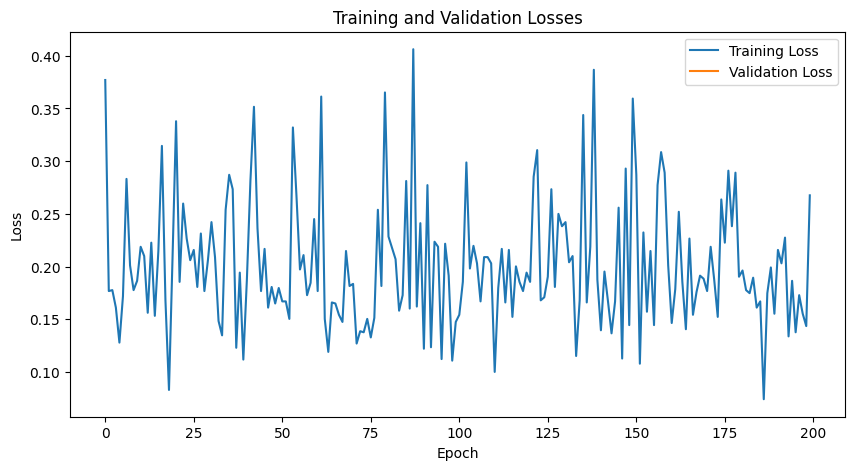

In [135]:
import matplotlib.pyplot as plt

training_loss = peft_trainer.state.log_history

train_losses = [log['loss']  for log in training_loss if 'loss' in log and 'eval_loss' not in log] 
eval_losses = [log['eval_loss'] for log in training_loss if 'eval_loss' in log ]

plt.figure(figsize=(10,5))

plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# SIZE/Dimension of Model
Check that the size of this model is much less than the original LLM:
Peft Pretained FLAN-T5 Model size has been reduced drastically to: (14M)

In [137]:
!ls -lh /tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200/adapter_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-rw-r--r-- 1 root root 14M May  7 15:32 /tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200/adapter_model.bin


Prepare this model by adding an adapter to the original FLAN-T5 model. You are setting `is_trainable=False` because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set `is_trainable=True`.

In [138]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(
                peft_model_base,
                '/tf/tensorflow-tutorials/peft_fine_tune_FlanT5_200',
                torch_dtype=torch.bfloat16,
                is_trainable=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The number of trainable parameters will be `0` due to `is_trainable=False` setting:

In [139]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


<a name='3.3'></a>
### 3.3 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [140]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
#print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: I'm thinking of upgrading my computer.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person2# and #Person1# are discussing the future of the computer.


<a name='3.4'></a>
### 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time). 

In [141]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]
    
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person2# asks #Person1# to send a letter to #...
1,In order to prevent employees from wasting tim...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person2# asks #Person1# to send a letter to #...
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person2# asks #Person1# to send a letter to #...
3,#Person2# arrives late because of traffic jam....,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# is going to work on the subway. #Per...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# is going to work on the subway. #Per...
5,#Person2# complains to #Person1# about the tra...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# is going to work on the subway. #Per...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,#Person2# and #Person1# are discussing the div...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,#Person2# and #Person1# are discussing the div...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,#Person2# and #Person1# are discussing the div...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: T...",Brian's birthday is coming. #Person1# invites ...,#Person1# wants to invite #Person2# to the par...


In [142]:
df.to_csv('final_dataset.csv',index=False)

In [145]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}
INSTRUCT MODEL:
{'rouge1': 0.2797270017270017, 'rouge2': 0.1110275075427855, 'rougeL': 0.23900213400213402, 'rougeLsum': 0.24021614782484346}
PEFT MODEL:
{'rouge1': 0.27204621868914386, 'rouge2': 0.023454581594116473, 'rougeL': 0.21009585711540243, 'rougeLsum': 0.21092103910647125}


Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the `data/dialogue-summary-training-results.csv` file. Load the values for the PEFT model now and check its performance compared to other models.

# Note
Consider that This Finetune Method with Peft is trained with very
few epochs and subset of dataset. Therefore, if you want to see real
improvement you need to download Fully FineTuned PEFT Flan T5 Model from Hugging Face


In [153]:
human_baseline_summaries = df['human_baseline_summaries'].values
original_model_summaries = df['original_model_summaries'].values
instruct_model_summaries = df['instruct_model_summaries'].values
peft_model_summaries = df['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2510566239316239, 'rouge2': 0.11535720375106562, 'rougeL': 0.229375, 'rougeLsum': 0.23316773504273502}
INSTRUCT MODEL:
{'rouge1': 0.3963109574151292, 'rouge2': 0.17159535752470317, 'rougeL': 0.28030869042025963, 'rougeLsum': 0.2818554346992377}
PEFT MODEL:
{'rouge1': 0.27204621868914386, 'rouge2': 0.023454581594116473, 'rougeL': 0.21009585711540243, 'rougeLsum': 0.21092103910647125}


The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [148]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: -0.77%
rouge2: -8.76%
rougeL: -2.89%
rougeLsum: -2.93%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [149]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -0.77%
rouge2: -8.76%
rougeL: -2.89%
rougeLsum: -2.93%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).